In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pypfopt.cla import CLA
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 6, 20), datetime.date(2022, 6, 18))

In [3]:
sharpes = pd.read_csv('sharpes.csv')
sharpes.head()

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858


<a href="https://www.advfn.com/nyse/newyorkstockexchange.asp?companies=P">NYSE listings</a>

In [6]:
KEEP_TOP_N = 50
sym = (
    'nuvb pana parr prbm fna pgre pke pk pkd ph pe psn pre prty payc pay '
    'psfe btu peb pgss pba pflt pnnt pei pfsi pmt pag pnr pen pom pfgc '
    'pdac pdot prm pcpc pki prgo psth prsp pbra pfe phh pm psx psxp pnx '
    'feng dnk phr doc pny pdm pir pck pcq pgp phk pnf pipp ping pf pnw '
    'pins pes phd pht mav mhi mio pxd pjc pipr pbi pvt pic picc pvtl pagp'
)
missing = (
    'pbra pdac pkd psxp pir pvt pes pvtl pjc pny pic prsp pe dnk'
)
SYMBOLS = [s for s in sym.split() if s not in missing.split()]
#SYMBOLS

In [7]:
data = (
    yf.download(SYMBOLS, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.columns = SYMBOLS
data.head()

[*********************100%***********************]  64 of 64 completed


,nuvb,pana,parr,prbm,fna,pgre,pke,pk,ph,psn,...,phd,pht,mav,mhi,mio,pxd,pipr,pbi,picc,pagp
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-20,NaN,NaN,8.173608,NaN,8.148030,8.551944,NaN,NaN,18.810707,NaN,...,NaN,NaN,103.843201,NaN,NaN,NaN,NaN,NaN,24.899443,76.069725
2012-06-21,NaN,NaN,7.782151,NaN,8.186337,8.624464,NaN,NaN,18.468840,NaN,...,NaN,NaN,102.872215,NaN,NaN,NaN,NaN,NaN,24.051739,71.505524
2012-06-22,NaN,NaN,7.954392,NaN,8.169921,8.590992,NaN,NaN,17.975922,NaN,...,NaN,NaN,103.510551,NaN,NaN,NaN,NaN,NaN,24.540251,73.531097
2012-06-25,NaN,NaN,7.609910,NaN,8.169921,8.602149,NaN,NaN,16.934416,NaN,...,NaN,NaN,103.753304,NaN,NaN,NaN,NaN,NaN,23.613525,69.683395
2012-06-26,NaN,NaN,7.328062,NaN,8.202752,8.663514,NaN,NaN,16.592543,NaN,...,NaN,NaN,103.645409,NaN,NaN,NaN,NaN,NaN,23.405188,71.372849


In [8]:
def get_daily_returns(x):
    n = len(x)
    x = np.array(x)
    return x[2:n] / x[1:(n - 1)] - 1 

In [9]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [10]:
new_sharpes = []
for stock in SYMBOLS:
    sharpe = get_sharpe(get_daily_returns(data[stock]))
    new_sharpes.append([stock, sharpe])
    
sharpe_df = (
    pd.DataFrame(new_sharpes, columns=['stock', 'sharpe'])
    .sort_values('sharpe', ascending=False))
sharpe_df.head(15)

,stock,sharpe
52,pnw,1.777967
24,pag,1.172984
13,pay,0.981872
45,pcq,0.791376
31,pcpc,0.787950
11,prty,0.729000
42,doc,0.680711
8,ph,0.666417
25,pnr,0.637128
32,pki,0.588516


In [11]:
sharpes = (
    pd.concat([sharpes, sharpe_df])
    .sort_values('sharpe', ignore_index=True, ascending=False)
    .drop_duplicates())
sharpes.head(20)

,stock,sharpe
0,ASAN,4.146624
1,efc,3.530101
2,lly,3.048137
3,eve,2.531150
4,chmt,2.475858
5,hhs,2.406309
6,bxsl,2.249160
7,APSG,2.178348
8,dwin,1.886962
9,pnw,1.777967


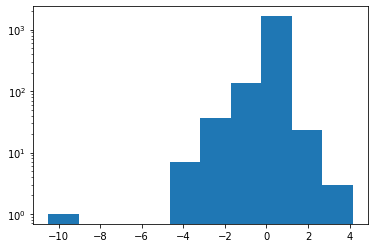

In [12]:
plt.hist(sharpes.sharpe)
plt.yscale('log');

In [13]:
sharpes.loc[sharpes.stock == 'cfx', :]

,stock,sharpe


In [14]:
omit = ('cfx')
inds = []
for o in omit.split():
    inds += (sharpes.loc[sharpes.stock == o, :].index.tolist())

sharpes.drop(index=inds, inplace=True)

In [15]:
sharpes.to_csv('sharpes.csv', index=False)

In [16]:
sharpes.shape

(1870, 2)

In [17]:
MIX = sharpes.stock.unique().tolist()[:400]
len(MIX)
df = yf.download(MIX, start=START, end=TODAY)
df.drop(
    columns=['Open', 'Close', 'Volume', 'High', 'Low'], inplace=True)
print(df.shape)
df.head()

[*********************100%***********************]  400 of 400 completed
(2521, 400)


Adj Close                                                     \
                  ABC      ABEV        ABM ACA      ACRE ADCT        ADM   
Date                                                                       
2012-06-20  32.379250  4.529084  16.841246 NaN  8.364583  NaN  22.837027   
2012-06-21  32.148941  4.435882  16.646826 NaN  8.122610  NaN  22.454885   
2012-06-22  32.353649  4.340815  16.582022 NaN  8.260201  NaN  22.378447   
2012-06-25  32.200123  4.372991  15.771955 NaN  8.108378  NaN  22.003952   
2012-06-26  32.166012  4.375916  16.071682 NaN  8.079908  NaN  21.881664   

                                            ...                            \
                 AEG        AEL        AEO  ... TCS       TFG         UAN   
Date                                        ...                             
2012-06-20  2.632168  10.059129  13.377145  ... NaN  4.302264  120.328392   
2012-06-21  2.557127   9.732005  13.238879  ... NaN  4.221643  118.791115   
2012-06-22  2.603306   9.786525  13.467014  ... NaN  4.377540  120.540405   
2012-06-25  2.453226   9.604788  13.293210  ... NaN  4.221200  122.554695   
2012-06-26  2.464771   9.559354  13.522638  ... NaN  4.142097  127.166397   

                                                              
                 VLT WEL       WLYB WNNR        XOM XPOA YOU  
Date                                                          
2012-06-20  7.406926 NaN  47.849998  NaN  56.484394  NaN NaN  
2012-06-21  7.424465 NaN  47.000000  NaN  54.583187  NaN NaN  
2012-06-22  7.485858 NaN  48.000000  NaN  54.583187  NaN NaN  
2012-06-25  7.455162 NaN  47.419998  NaN  54.004848  NaN NaN  
2012-06-26  7.455162 NaN  47.950001  NaN  54.775948  NaN NaN  

[5 rows x 400 columns]

In [18]:
df.columns = MIX
MAX_MISSING = 30
n_nan = df.isnull().sum()
n_nan
drop = n_nan[n_nan > MAX_MISSING].index
df = df.drop(columns=drop)
print(df.shape)
df.head()

(2521, 228)


,ASAN,efc,lly,chmt,bxsl,APSG,dwin,pnw,irs,axh,...,orcc,nkg,itgr,matx,asr,clpr,este,pki,moh,cnx
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-20,32.379250,4.529084,16.841246,8.364583,22.837027,2.632168,10.059129,13.377145,27.597374,8.476770,...,84.610580,115.910004,9.576717,68.290939,32.244755,4.302264,120.328392,7.406926,47.849998,56.484394
2012-06-21,32.148941,4.435882,16.646826,8.122610,22.454885,2.557127,9.732005,13.238879,27.221422,8.500950,...,83.217697,112.910004,9.560220,64.734131,31.529470,4.221643,118.791115,7.424465,47.000000,54.583187
2012-06-22,32.353649,4.340815,16.582022,8.260201,22.378447,2.603306,9.786525,13.467014,27.325851,8.534792,...,83.695518,115.110001,9.494232,65.919708,31.667645,4.377540,120.540405,7.485858,48.000000,54.583187
2012-06-25,32.200123,4.372991,15.771955,8.108378,22.003952,2.453226,9.604788,13.293210,27.270153,8.544467,...,82.982864,114.790001,9.617963,64.813179,31.805826,4.221200,122.554695,7.455162,47.419998,54.004848
2012-06-26,32.166012,4.375916,16.071682,8.079908,21.881664,2.464771,9.559354,13.522638,27.423317,8.549304,...,83.800774,117.370003,9.510727,65.840668,32.017155,4.142097,127.166397,7.455162,47.950001,54.775948


In [19]:
import cvxpy
cvxpy.installed_solvers()

['ECOS', 'ECOS_BB', 'OSQP', 'SCIPY', 'SCS']

In [20]:
mu = mean_historical_return(df)
s = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, s, solver='ECOS')# , verbose=True)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

mlm   : 0.03163
mfv   : 0.11681
fnv   : 0.08762
lub   : 0.01588
ipi   : 0.04909
gmed  : 0.05706
nee   : 0.01427
bmy   : 0.05231
gsqb  : 0.15983
clbr  : 0.02889
br    : 0.04015
oacb  : 0.02115
hlt   : 0.04471
gnrt  : 0.08435
clpr  : 0.19625


In [21]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 19.3%
Annual volatility: 12.7%
Sharpe Ratio: 1.37


In [22]:
s1

1.3684175158187917

In [23]:
vol = np.linspace(0.10, 0.30, 50)
rets = []
sharpes = []
for v in vol:
    print(f'Vol: {v}   ', end='\r')
    ef = EfficientFrontier(mu, s, solver='ECOS')
    w = ef.efficient_risk(target_volatility=v)
    r, _, sh = ef.portfolio_performance()
    rets.append(r)
    sharpes.append(sh)

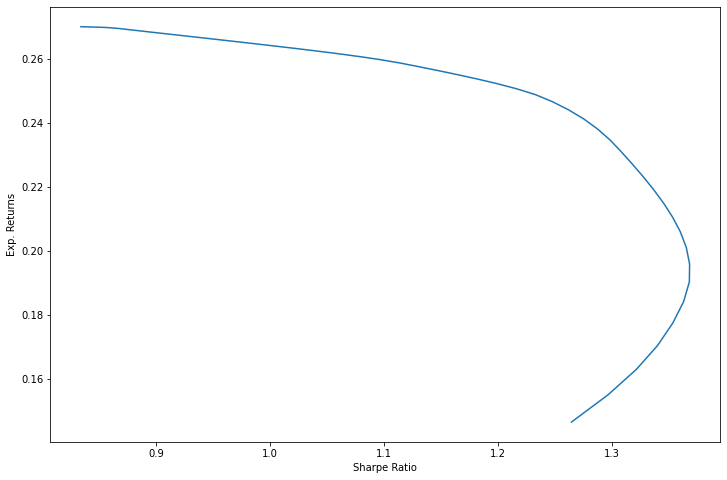

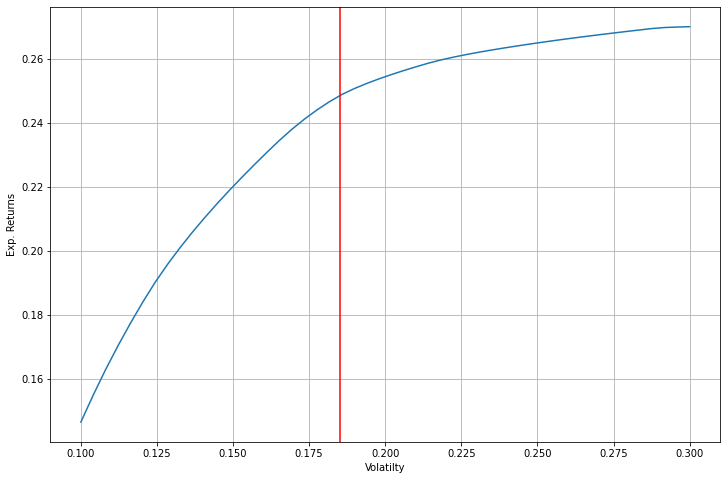

In [28]:
plt.figure(figsize=[12,8])
plt.plot(sharpes, rets)
plt.xlabel('Sharpe Ratio')
plt.ylabel('Exp. Returns');

plt.figure(figsize=[12,8])
plt.plot(vol, rets)
plt.grid(True)
plt.axvline(x=0.185, color='r')
plt.xlabel('Volatilty')
plt.ylabel('Exp. Returns');

In [29]:
OPTIMAL_VOL = 0.185
ef = EfficientFrontier(mu, s, solver='ECOS')
weights = ef.efficient_risk(target_volatility=OPTIMAL_VOL)
cleaned_weights = ef.clean_weights()
for k, v in dict(cleaned_weights).items():
    if v > 0:
        print(f'{k:6s}: {v}')

mlm   : 0.06304
mfv   : 0.17231
fnv   : 0.11266
gsqb  : 0.32101
clbr  : 0.07096
br    : 0.11213
hlt   : 0.14789


In [30]:
_, _, s1 = ef.portfolio_performance(verbose=True)

Expected annual return: 24.9%
Annual volatility: 18.5%
Sharpe Ratio: 1.24


In [31]:
s1

1.2353622567170743